In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns
from scipy.special import rel_entr

In [31]:
df18 = pd.read_csv("../exp2-inf/predictions_res18_2.csv")
df50 = pd.read_csv("../exp2-inf/predictions_res50_2.csv")
df101 = pd.read_csv("../exp2-inf/predictions_res101_2.csv")
label = pd.read_csv("../exp2-inf/labels.csv")

In [32]:
prediction = pd.DataFrame({
    "pred18": df18.idxmax(axis=1),
    "pred50": df50.idxmax(axis=1),
    "pred101": df101.idxmax(axis=1),
    "target": label['target']
})
prediction["pred18"] = prediction["pred18"].str.extract('(\d+)').astype(int)
prediction["pred50"] = prediction["pred50"].str.extract('(\d+)').astype(int)
prediction["pred101"] = prediction["pred101"].str.extract('(\d+)').astype(int)
print("Here's the Prediction Dataframe")
prediction.head()

Here's the Prediction Dataframe


,pred18,pred50,pred101,target
0,24,24,24,24
1,77,77,77,77
2,252,252,252,252
3,144,144,144,144
4,224,224,224,224


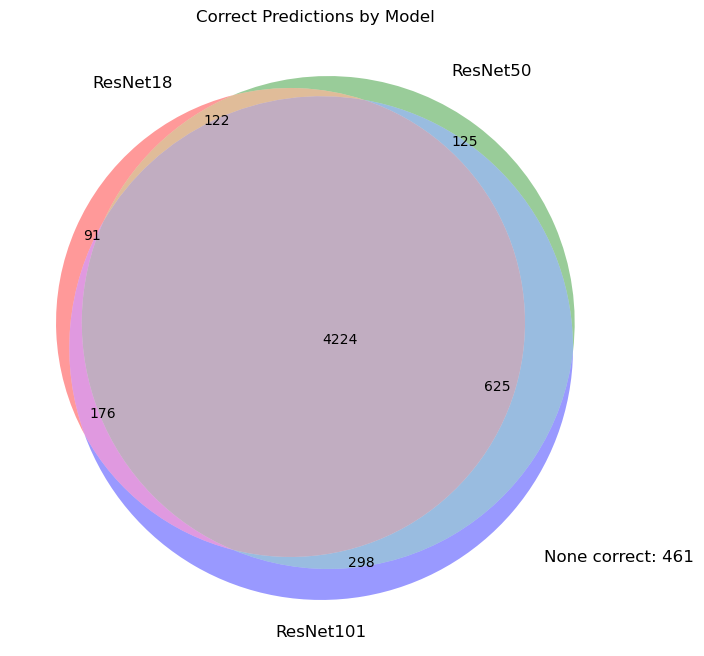

In [33]:
df = prediction
correct_18 = set(df[df['pred18'] == df['target']].index)
correct_50 = set(df[df['pred50'] == df['target']].index)
correct_101 = set(df[df['pred101'] == df['target']].index)
total_indices = set(df.index)
incorrect_all = total_indices - (correct_18 | correct_50 | correct_101)
plt.figure(figsize=(8, 8))
venn_diagram = venn3([correct_18, correct_50, correct_101], ('ResNet18', 'ResNet50', 'ResNet101'))
plt.title('Correct Predictions by Model')
plt.text(0.5, -0.5, f'None correct: {len(incorrect_all)}', fontsize=12)
plt.show()

In [34]:
print(f"sanity check: \n{len(correct_101 - correct_18)= }, \n{280 + 617 = }")

sanity check: 
len(correct_101 - correct_18)= 923, 
280 + 617 = 897


In [35]:
c18i50 = list(correct_18-correct_50)
c18i50.sort()
c18i101 = list(correct_18-correct_101)
c18i101.sort()
c50i18 = list(correct_50-correct_18)
c50i18.sort()
c50i101 = list(correct_50-correct_101)
c50i101.sort()
c101i18 = list(correct_101-correct_18)
c101i18.sort()
c101i50 = list(correct_101-correct_50)
c101i50.sort()

In [36]:
def incVsCorConfOnTrueLabel(index_set, pred_cor, pred_inc):
    label = df.loc[index_set, 'target'].apply(lambda x: f'class_{x}').tolist()
    conf_cor = np.zeros(len(index_set))
    conf_inc = np.zeros(len(index_set))
    for i in range(len(index_set)):
        conf_cor[i] = pred_cor.loc[index_set[i],label[i]]
        conf_inc[i] = pred_inc.loc[index_set[i],label[i]]
    # print("Correct Model has average confidence of:")
    print(f"{conf_cor.mean() = }")
    # print("Incorrect Model has average confidence of:")
    print(f"{conf_inc.mean() = }")
    
print("c18i50")
incVsCorConfOnTrueLabel(c18i50,df18,df50)    
print("c18i101")
incVsCorConfOnTrueLabel(c18i101,df18,df101)    
print("c50i18")
incVsCorConfOnTrueLabel(c50i18,df50,df18)    
print("c50i101")
incVsCorConfOnTrueLabel(c50i101,df50,df101)    
print("c101i18")
incVsCorConfOnTrueLabel(c101i18,df101,df18)    
print("c101i50")
incVsCorConfOnTrueLabel(c101i50,df101,df50)

c18i50
conf_cor.mean() = 0.2701220753258427
conf_inc.mean() = 0.11031651277677902
c18i101
conf_cor.mean() = 0.29336736300469485
conf_inc.mean() = 0.11660591083551174
c50i18
conf_cor.mean() = 0.5992976428960001
conf_inc.mean() = 0.04661371848766667
c50i101
conf_cor.mean() = 0.5030520839190284
conf_inc.mean() = 0.12600858330040485
c101i18
conf_cor.mean() = 0.838637129020585
conf_inc.mean() = 0.0432379130415493
c101i50
conf_cor.mean() = 0.7849766509704641
conf_inc.mean() = 0.09573566186434598


Next step:
1. for test images where no model predicts correctly, how are their confidence like?
2. Confidence among classes and between classes (ANOVA)?

In [37]:
label_c18i50 = df.loc[c18i50, 'target'].apply(lambda x: f'class_{x}').tolist()
label_c18i101 = df.loc[c18i101, 'target'].apply(lambda x: f'class_{x}').tolist()
label_c50i18 = df.loc[c50i18, 'target'].apply(lambda x: f'class_{x}').tolist()
label_c50i101 = df.loc[c50i101, 'target'].apply(lambda x: f'class_{x}').tolist()
label_c101i18 = df.loc[c101i18, 'target'].apply(lambda x: f'class_{x}').tolist()
label_c101i50 = df.loc[c101i50, 'target'].apply(lambda x: f'class_{x}').tolist()

In [38]:
def incVsCorConfOnPred(labelSet,indexSet,predCor,predInc):
    confidence_Of_Correct_Model = np.zeros(len(indexSet))
    confidence_Of_Incorrect_Model = np.zeros(len(indexSet))
    for i in range(len(indexSet)):
        confidence_Of_Correct_Model[i] = predCor.loc[indexSet[i],labelSet[i]]
        confidence_Of_Incorrect_Model[i] = max(predInc.loc[indexSet[i]])
    print(f"{confidence_Of_Correct_Model.mean() = }")
    print(f"{confidence_Of_Incorrect_Model.mean() = }")
print("c18i50")
incVsCorConfOnPred(label_c18i50,c18i50,df18,df50)
print("c18i101")
incVsCorConfOnPred(label_c18i101,c18i101,df18,df101)
print("c50i18")
incVsCorConfOnPred(label_c50i18,c50i18,df50,df18)
print("c50i101")
incVsCorConfOnPred(label_c50i101,c50i101,df50,df101)
print("c101i18")
incVsCorConfOnPred(label_c101i18,c101i18,df101,df18)
print("c101i50")
incVsCorConfOnPred(label_c101i50,c101i50,df101,df50)

c18i50
confidence_Of_Correct_Model.mean() = 0.2701220753258427
confidence_Of_Incorrect_Model.mean() = 0.3643330815018726
c18i101
confidence_Of_Correct_Model.mean() = 0.29336736300469485
confidence_Of_Incorrect_Model.mean() = 0.6234603930985915
c50i18
confidence_Of_Correct_Model.mean() = 0.5992976428960001
confidence_Of_Incorrect_Model.mean() = 0.15503623696333332
c50i101
confidence_Of_Correct_Model.mean() = 0.5030520839190284
confidence_Of_Incorrect_Model.mean() = 0.5876574720242917
c101i18
confidence_Of_Correct_Model.mean() = 0.838637129020585
confidence_Of_Incorrect_Model.mean() = 0.1535996913840737
c101i50
confidence_Of_Correct_Model.mean() = 0.7849766509704641
confidence_Of_Incorrect_Model.mean() = 0.32049722608016873


In [39]:
incorrect_all = list(incorrect_all)
incorrect_all.sort()
def incorrectPredConf(indexSet,predInc1,predInc2,predInc3):
    confidence_Of_Incorrect_Model1 = np.zeros(len(indexSet))
    confidence_Of_Incorrect_Model2 = np.zeros(len(indexSet))
    confidence_Of_Incorrect_Model3 = np.zeros(len(indexSet))
    for i in range(len(indexSet)):
        confidence_Of_Incorrect_Model1[i] = max(predInc1.loc[indexSet[i]])
        confidence_Of_Incorrect_Model2[i] = max(predInc2.loc[indexSet[i]])
        confidence_Of_Incorrect_Model3[i] = max(predInc3.loc[indexSet[i]])
    print(f"{confidence_Of_Incorrect_Model1.mean() = }")
    print(f"{confidence_Of_Incorrect_Model2.mean() = }")
    print(f"{confidence_Of_Incorrect_Model3.mean() = }")
    print(f"{confidence_Of_Incorrect_Model1.var() = }")
    print(f"{confidence_Of_Incorrect_Model2.var() = }")
    print(f"{confidence_Of_Incorrect_Model3.var() = }")
incorrectPredConf(incorrect_all,df18,df50,df101)

confidence_Of_Incorrect_Model1.mean() = 0.16719592680043383
confidence_Of_Incorrect_Model2.mean() = 0.33831731036008683
confidence_Of_Incorrect_Model3.mean() = 0.6007289279522777
confidence_Of_Incorrect_Model1.var() = 0.046937850603410644
confidence_Of_Incorrect_Model2.var() = 0.0765885422994051
confidence_Of_Incorrect_Model3.var() = 0.08750404294852475


Note: The larger the neural net, the more confident in its mistakes.

In [40]:
df18["uncertainty"]=1-df18.pow(2).sum(axis=1) # Brier Score
df50["uncertainty"]=1-df50.pow(2).sum(axis=1)
df101["uncertainty"]=1-df101.pow(2).sum(axis=1)
def incorrectPredConf(indexSet,predInc1,predInc2,predInc3):
    unc_Of_Incorrect_Model1 = np.zeros(len(indexSet))
    unc_Of_Incorrect_Model2 = np.zeros(len(indexSet))
    unc_Of_Incorrect_Model3 = np.zeros(len(indexSet))
    for i in range(len(indexSet)):
        unc_Of_Incorrect_Model1[i] = predInc1.loc[indexSet[i],"uncertainty"]
        unc_Of_Incorrect_Model2[i] = predInc2.loc[indexSet[i],"uncertainty"]
        unc_Of_Incorrect_Model3[i] = predInc3.loc[indexSet[i],"uncertainty"]
    print(f"{unc_Of_Incorrect_Model1.mean() = }")
    print(f"{unc_Of_Incorrect_Model2.mean() = }")
    print(f"{unc_Of_Incorrect_Model3.mean() = }")
    print(f"{unc_Of_Incorrect_Model1.var() = }")
    print(f"{unc_Of_Incorrect_Model2.var() = }")
    print(f"{unc_Of_Incorrect_Model3.var() = }")
incorrectPredConf(incorrect_all,df18,df50,df101)

unc_Of_Incorrect_Model1.mean() = 0.9163434406015804
unc_Of_Incorrect_Model2.mean() = 0.7916804009985581
unc_Of_Incorrect_Model3.mean() = 0.5242814085465055
unc_Of_Incorrect_Model1.var() = 0.032473463308254236
unc_Of_Incorrect_Model2.var() = 0.06457577665000806
unc_Of_Incorrect_Model3.var() = 0.11017152587687455


In [41]:
# Overall Uncertainty:
ou_res18 = df18["uncertainty"].mean()
ou_res50 = df50["uncertainty"].mean()
ou_res101 = df101["uncertainty"].mean()
print(f"{ou_res18=} | {ou_res50=} | {ou_res101=}")

ou_res18=0.5967268844268535 | ou_res50=0.35323308562895256 | ou_res101=0.15073991393094044


Text(0, 0.5, 'Density')

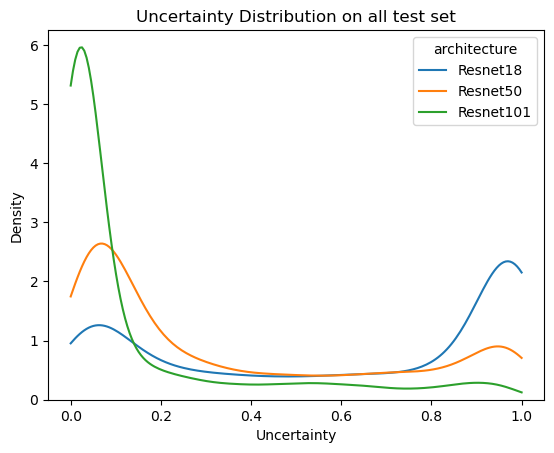

In [42]:
sns.kdeplot(df18['uncertainty'], clip=[0, 1], label='Resnet18')
sns.kdeplot(df50['uncertainty'], clip=[0, 1], label='Resnet50')
sns.kdeplot(df101['uncertainty'], clip=[0, 1], label='Resnet101')
plt.legend(title='architecture')
plt.title('Uncertainty Distribution on all test set')
plt.xlabel('Uncertainty')
plt.ylabel('Density')


Text(0, 0.5, 'Density')

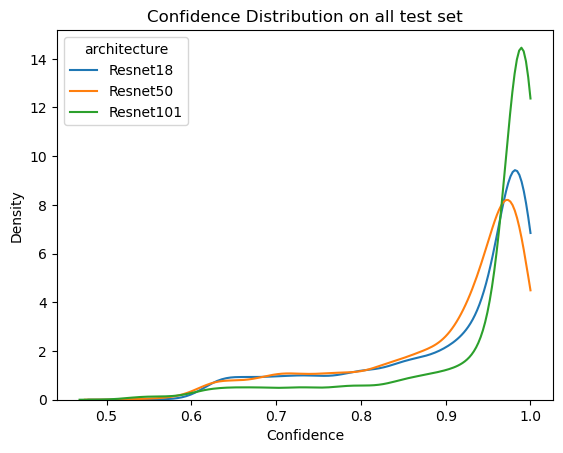

In [43]:
df18["confidence"]=df18.max(axis=1) # prediction confidence
df50["confidence"]=df50.max(axis=1)
df101["confidence"]=df101.max(axis=1)
sns.kdeplot(df18['confidence'], clip=[0, 1], label='Resnet18')
sns.kdeplot(df50['confidence'], clip=[0, 1], label='Resnet50')
sns.kdeplot(df101['confidence'], clip=[0, 1], label='Resnet101')
plt.title('Confidence Distribution on all test set')
plt.legend(title='architecture')
plt.xlabel('Confidence')
plt.ylabel('Density')

In [44]:
oc_res18 = df18["confidence"].mean()
oc_res50 = df50["confidence"].mean()
oc_res101 = df101["confidence"].mean()
print(f"{oc_res18=} | {oc_res50=} | {oc_res101=}")
ocv_res18 = df18["confidence"].var()
ocv_res50 = df50["confidence"].var()
ocv_res101 = df101["confidence"].var()
print(f"{ocv_res18=} | {ocv_res50=} | {ocv_res101=}")

oc_res18=0.9039513037027024 | oc_res50=0.8942049228363482 | oc_res101=0.9388096569812723
ocv_res18=0.011336725580470055 | ocv_res50=0.011109865817257888 | ocv_res101=0.009759653118642873


In [45]:
cor_conf_18 = df18[df['pred18'] == df['target']]["confidence"].mean()
cor_conf_50 = df50[df['pred50'] == df['target']]["confidence"].mean()
cor_conf_101 = df101[df['pred101'] == df['target']]["confidence"].mean()

inc_conf_18 = df18[df['pred18'] != df['target']]["confidence"].mean()
inc_conf_50 = df50[df['pred50'] != df['target']]["confidence"].mean()
inc_conf_101 = df101[df['pred101'] != df['target']]["confidence"].mean()

print(f"{cor_conf_18 = } | {inc_conf_18 = }")
print(f"{cor_conf_50 = } | {inc_conf_50 = }")
print(f"{cor_conf_101 = } | {inc_conf_101 = }")

cor_conf_18 = 0.8889935316025007 | inc_conf_18 = 0.9496770841521588
cor_conf_50 = 0.8989051001669106 | inc_conf_50 = 0.8708597925473174
cor_conf_101 = 0.9557164756304444 | inc_conf_101 = 0.8261751192221453


Interesting thing here is that the larger the model is the less confident it is in incorrect predictions: 
- Resnet 18 is more confident in incorrect predictions compared to correct predictions;
- Resnet 50 has roughly the same confidence in incorrect predictions compared to correct predictions;
- Resnet 101 is less confident in incorrect predictions compared to correct predictions;

In [46]:
def calc_kl(Q,P):
    return rel_entr(Q.iloc[:,0:257],P.iloc[:,0:257]).sum(1)
df18["kl_18_50"] = calc_kl(df18,df50)
df18["kl_18_101"] = calc_kl(df18,df101)
df50["kl_50_18"] = calc_kl(df50,df18)
df50["kl_50_101"] = calc_kl(df50,df101)
df101["kl_101_18"] = calc_kl(df101,df18)
df101["kl_101_50"] = calc_kl(df101,df50)

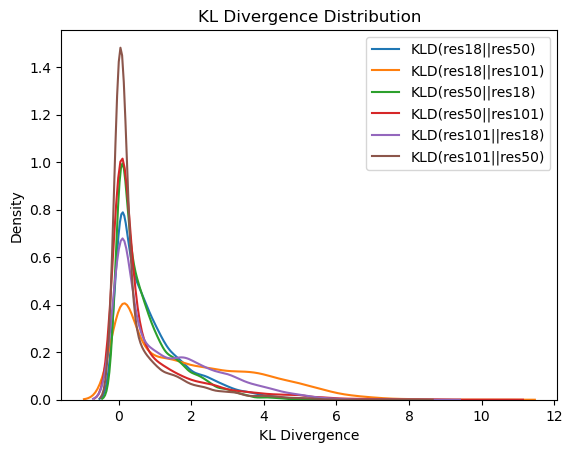

In [47]:
sns.kdeplot(df18["kl_18_50"], label='KLD(res18||res50)')
sns.kdeplot(df18["kl_18_101"], label='KLD(res18||res101)')
sns.kdeplot(df50["kl_50_18"], label='KLD(res50||res18)')
sns.kdeplot(df50["kl_50_101"], label='KLD(res50||res101)')
sns.kdeplot(df101["kl_101_18"], label='KLD(res101||res18)')
sns.kdeplot(df101["kl_101_50"], label='KLD(res101||res50)')
plt.title('KL Divergence Distribution')
plt.xlabel('KL Divergence')
plt.ylabel('Density')
plt.legend()

In [48]:
df["cor18"] = np.where(df["pred18"]==df["target"],1,0)
df["cor50"] = np.where(df["pred50"]==df["target"],1,0)
df["cor101"] = np.where(df["pred101"]==df["target"],1,0)
df.head(3)

,pred18,pred50,pred101,target,cor18,cor50,cor101
0,24,24,24,24,1,1,1
1,77,77,77,77,1,1,1
2,252,252,252,252,1,1,1


<Axes: xlabel='kl_18_50', ylabel='cor18'>

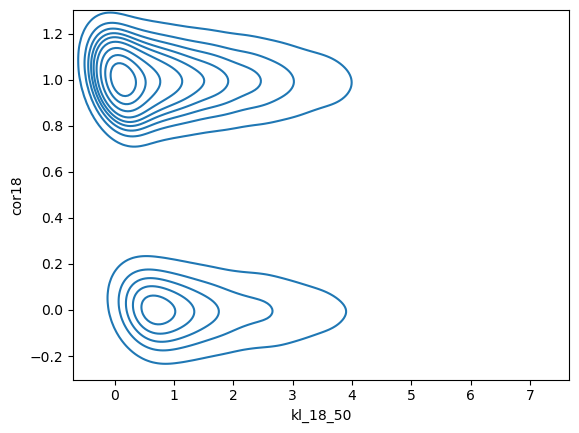

In [49]:
sns.kdeplot(x = df18["kl_18_50"],y = df["cor18"])

In [50]:
binnum=10

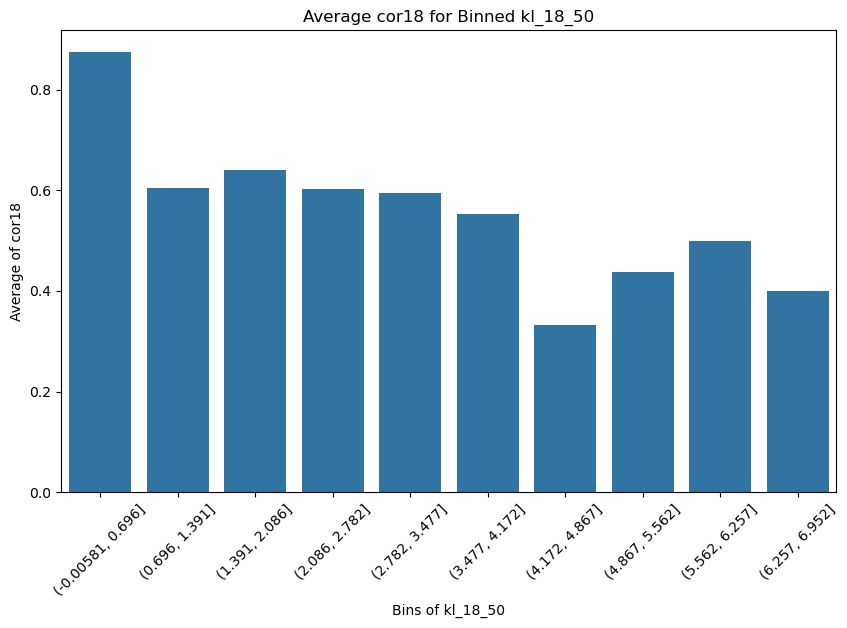

In [51]:
df18['bin_kl1850'] = pd.cut(df18['kl_18_50'], bins=binnum)
df18['bin_kl18101'] = pd.cut(df18['kl_18_101'], bins=binnum)
df18["corr"] = df["cor18"]
df50["corr"] = df["cor50"]
df101["corr"] = df["cor101"]
grouped_kl1850 = df18.groupby('bin_kl1850')['corr'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='bin_kl1850', y='corr', data=grouped_kl1850)
plt.xlabel('Bins of kl_18_50')
plt.ylabel('Average of cor18')
plt.title('Average cor18 for Binned kl_18_50')
plt.xticks(rotation=45)
plt.show()

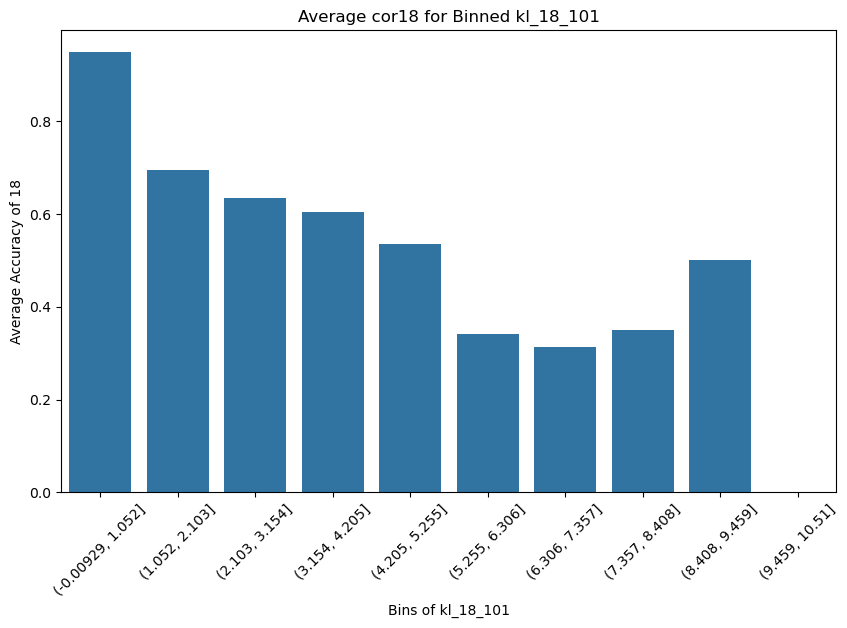

In [52]:
grouped_kl18101 = df18.groupby('bin_kl18101')['corr'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='bin_kl18101', y='corr', data=grouped_kl18101)
plt.xlabel('Bins of kl_18_101')
plt.ylabel('Average Accuracy of 18')
plt.title('Average cor18 for Binned kl_18_101')
plt.xticks(rotation=45)
plt.show()

In [53]:
df50['bin_kl5018'] = pd.cut(df50['kl_50_18'], bins=binnum)
df50['bin_kl50101'] = pd.cut(df50['kl_50_101'], bins=binnum)
df50.head()

,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_254,class_255,class_256,uncertainty,confidence,kl_50_18,kl_50_101,corr,bin_kl5018,bin_kl50101
0,0.005948,0.004832,0.001660,0.005637,0.002969,0.001801,0.003205,0.002289,0.002845,0.001906,...,0.001363,0.001850,0.003220,0.971939,0.971939,0.457211,3.167850,1,"(-0.00588, 0.705]","(3.143, 4.19]"
1,0.002046,0.002737,0.001032,0.001026,0.002267,0.000385,0.000711,0.001522,0.001411,0.001574,...,0.001750,0.001507,0.008682,0.804020,0.804020,0.264720,1.225297,1,"(-0.00588, 0.705]","(1.048, 2.095]"
2,0.000077,0.000048,0.000115,0.000057,0.000189,0.000057,0.000086,0.000077,0.000059,0.000067,...,0.000055,0.000086,0.000134,0.041591,0.978982,0.017128,0.009780,1,"(-0.00588, 0.705]","(-0.00981, 1.048]"
3,0.000025,0.000024,0.000068,0.000026,0.000024,0.000026,0.000028,0.000033,0.000013,0.000023,...,0.000049,0.000052,0.000025,0.017774,0.991073,0.044216,0.005707,1,"(-0.00588, 0.705]","(-0.00981, 1.048]"
4,0.001284,0.002146,0.001958,0.003460,0.004355,0.000963,0.003049,0.003599,0.002019,0.001644,...,0.002487,0.004081,0.003130,0.970533,0.970533,0.973988,3.666064,1,"(0.705, 1.409]","(3.143, 4.19]"


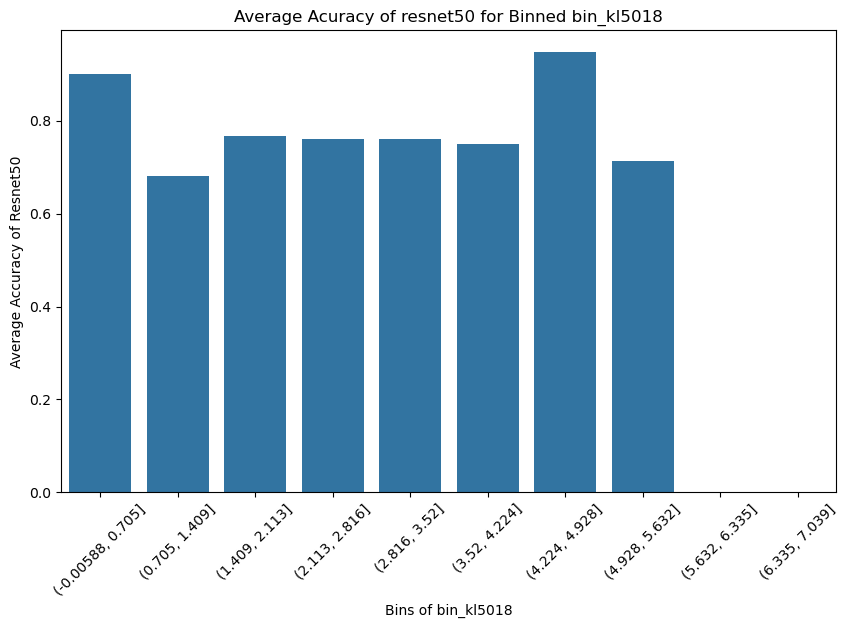

In [54]:
grouped_kl5018 = df50.groupby('bin_kl5018')['corr'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='bin_kl5018', y='corr', data=grouped_kl5018)
plt.xlabel('Bins of bin_kl5018')
plt.ylabel('Average Accuracy of Resnet50')
plt.title('Average Acuracy of resnet50 for Binned bin_kl5018')
plt.xticks(rotation=45)
plt.show()

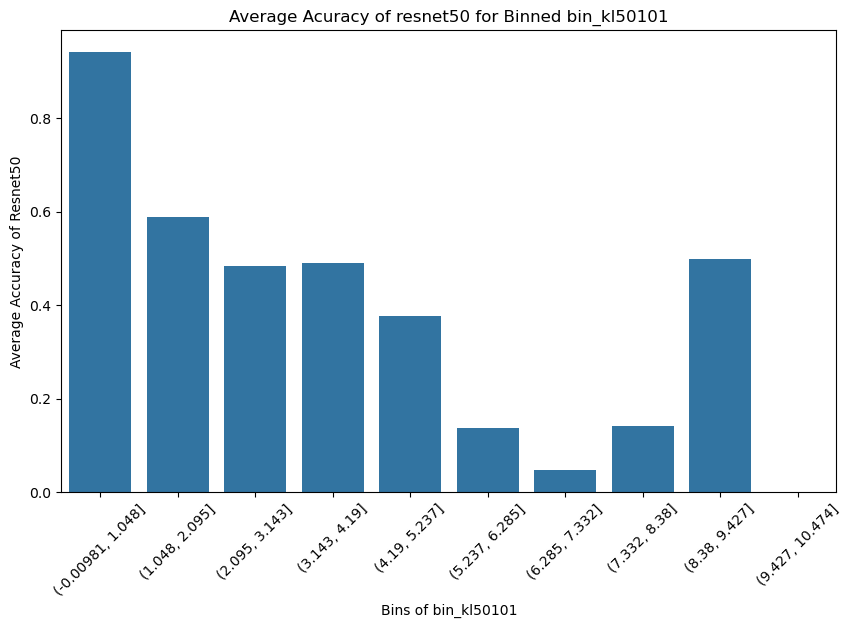

In [55]:
grouped_kl50101 = df50.groupby('bin_kl50101')['corr'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='bin_kl50101', y='corr', data=grouped_kl50101)
plt.xlabel('Bins of bin_kl50101')
plt.ylabel('Average Accuracy of Resnet50')
plt.title('Average Acuracy of resnet50 for Binned bin_kl50101')
plt.xticks(rotation=45)
plt.show()

In [56]:
df101['bin_kl10118'] = pd.cut(df101['kl_101_18'], bins=binnum)
df101['bin_kl10150'] = pd.cut(df101['kl_101_50'], bins=binnum)
df101.head()

,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_254,class_255,class_256,uncertainty,confidence,kl_101_18,kl_101_50,corr,bin_kl10118,bin_kl10150
0,0.000012,0.000211,0.000020,0.000049,0.000070,0.000075,0.000084,0.000053,0.000040,0.000068,...,0.000042,0.000036,0.000246,0.103120,0.946620,3.726702,1.669953,1,"(3.479, 4.349]","(1.631, 2.446]"
1,0.000051,0.000059,0.000091,0.000232,0.000220,0.000083,0.000392,0.000066,0.000192,0.000019,...,0.000181,0.000221,0.000261,0.130451,0.932299,0.609247,0.625397,1,"(-0.00792, 0.87]","(-0.00762, 0.816]"
2,0.000123,0.000021,0.000055,0.000104,0.000061,0.000023,0.000044,0.000018,0.000022,0.000045,...,0.000018,0.000058,0.000304,0.023787,0.988034,0.008508,0.006407,1,"(-0.00792, 0.87]","(-0.00762, 0.816]"
3,0.000029,0.000030,0.000099,0.000063,0.000050,0.000070,0.000041,0.000048,0.000041,0.000036,...,0.000138,0.000059,0.000031,0.033520,0.983097,0.032851,0.008907,1,"(-0.00792, 0.87]","(-0.00762, 0.816]"
4,0.000026,0.000328,0.000087,0.000169,0.000062,0.000046,0.000037,0.000023,0.000023,0.000061,...,0.000047,0.000085,0.000168,0.049939,0.974705,0.503336,2.002967,1,"(-0.00792, 0.87]","(1.631, 2.446]"


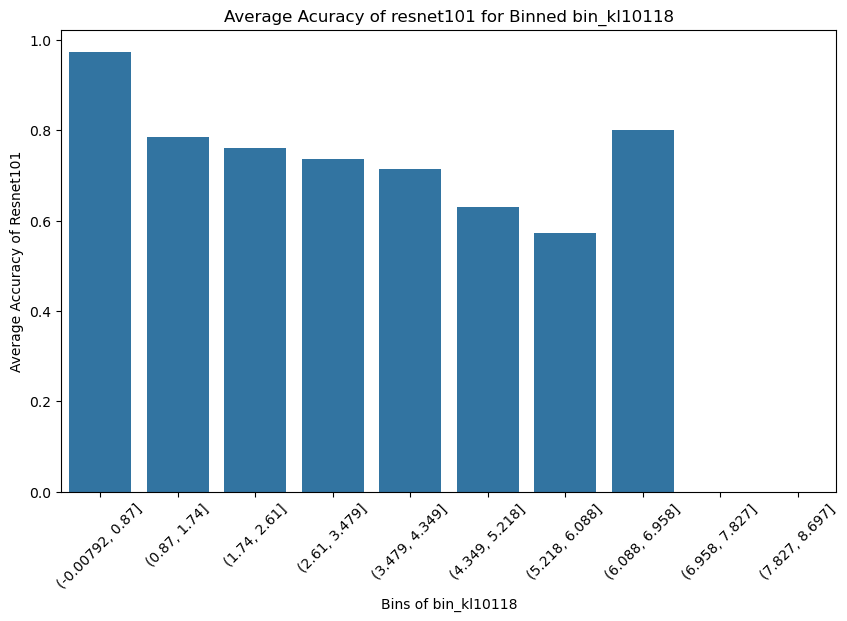

In [57]:
grouped_kl10118 = df101.groupby('bin_kl10118')['corr'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='bin_kl10118', y='corr', data=grouped_kl10118)
plt.xlabel('Bins of bin_kl10118')
plt.ylabel('Average Accuracy of Resnet101')
plt.title('Average Acuracy of resnet101 for Binned bin_kl10118')
plt.xticks(rotation=45)
plt.show()

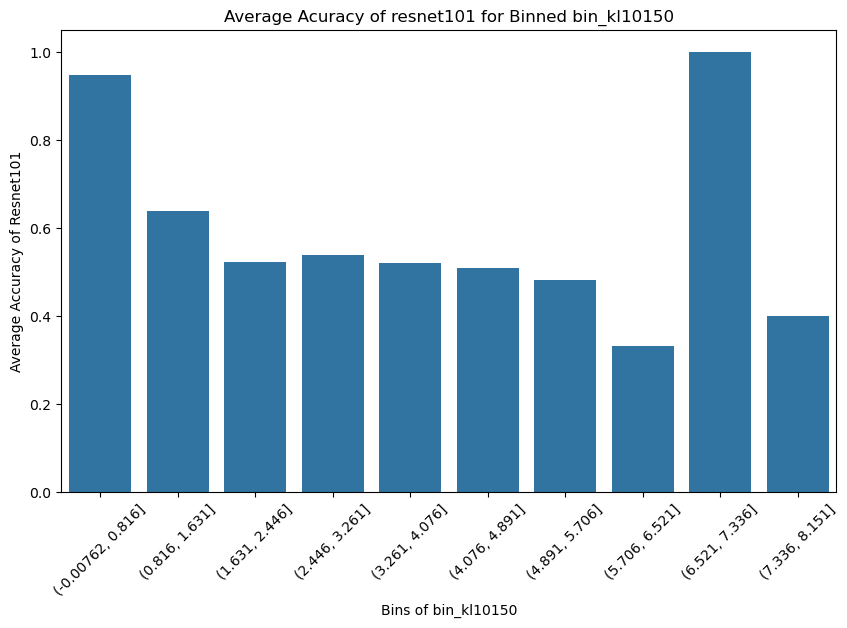

In [58]:
grouped_kl10150 = df101.groupby('bin_kl10150')['corr'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='bin_kl10150', y='corr', data=grouped_kl10150)
plt.xlabel('Bins of bin_kl10150')
plt.ylabel('Average Accuracy of Resnet101')
plt.title('Average Acuracy of resnet101 for Binned bin_kl10150')
plt.xticks(rotation=45)
plt.show()